In [152]:
import torch.nn as nn
import torch
lstm = torch.load(f"lstmAdamWLr0_01VecSize600Acc83_4.model")
linear = torch.load(f"linearAdamWLr0_01VecSize600Acc83_4.model")
cuda = torch.device('cuda')

In [153]:
import csv
import sys
import datetime

csv.field_size_limit(int(sys.maxsize / 100000000000))
texts = []
signs = []
dates = []
all_texts = []
with open('./signed_stem.csv', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        if row[2] == 'Date':
            continue
        all_texts.append(row[3])
        date = datetime.datetime.strptime(row[2], "%Y-%m-%d")
        if date >= datetime.datetime(2023, 1, 1):
            dates.append(date)
            texts.append(row[3])
            signs.append(row[8])

In [154]:
import numpy as np
from gensim.models import Word2Vec
import time

sentences = [text.split(' ') for text in all_texts]
start = time.time()
model = Word2Vec(sentences=sentences, vector_size=600, window=5, min_count=2, workers=20)
model.save("word2vec.model")
end = time.time()
print(end - start)

86.56809687614441


In [155]:
vectors = [[model.wv[w] for w in text.split(' ') if w in model.wv] for text in texts]

In [156]:
print(model.wv.most_similar('газ'))

[('газа»', 0.6877519488334656), ('энергоресурс', 0.5999186038970947), ('энергоносител', 0.5785380005836487), ('электроэнерг', 0.5488095879554749), ('газов', 0.5260836482048035), ('топлив', 0.5087995529174805), ('нефтепродукт', 0.4946277141571045), ('углеводород', 0.4866407811641693), ('спг', 0.48499247431755066), ('пхг', 0.47549954056739807)]


In [157]:
import torch.optim as optim

X = vectors
classes = [-1, 0, 1]
for i in range(len(signs)):
    signs[i] = int(signs[i])
y = torch.zeros(len(vectors), 3, device='cuda:0')
for i in range(len(vectors)):
    y[i][classes.index(signs[i])] = 1

In [158]:
count = int(len(X) * 0.7)
val_count = int(len(X) * 0.8)

In [159]:
relu = nn.Softmax(dim=0)
relu.to("cuda:0")

Ypred = torch.tensor([])
for i in range(len(X)):
    hidden = (
        torch.rand(1 * 2, 100, device='cuda:0'),
        torch.rand(1 * 2, 100, device='cuda:0')
    )
    x = np.array(X[i])
    out, _ = lstm(torch.cuda.FloatTensor(x, device='cuda:0'), hidden)
    out = linear(out[-1])
    out = relu(out)
    yPred = out
    Ypred = torch.cat((Ypred, yPred.detach().cpu().reshape(1, 3)), 0)

In [160]:
def accuracy(Ytrain, Ypred):
    count = 0
    for i in range(len(Ytrain)):
        _max = 0
        j_max = 0
        for j in range(len(Ypred[i])):
            if _max < yPred[j]:
                _max = yPred[j]
                j_max = j
        if Ytrain[i][j_max] == 1:
            count += 1
    return count / len(Ytrain)

In [161]:
accuracy(y, Ypred)

0.6832560101223113

In [162]:
date_counts = {}
date_score = {}
classes = [-1, 0, 1]
for i in range(len(y)):
    date = dates[i]
    if date in date_counts:
        date_counts[date] += 1
    else:
        date_counts[date] = 0
    if date in date_score:
        date_score[date] += classes[torch.argmax(y[i]).item()]
    else:
        date_score[date] = 0
for date in sorted(date_counts.keys()):
    date_score[date] /= date_counts[date]

In [163]:
import openpyxl

funds = openpyxl.load_workbook("./gazprom-moscow-exchange.xlsx")
funds = funds.active
date_is = []
for i in range(1, funds.max_row - 1):
    try:
        date = datetime.datetime.strptime(funds['A'][i].value, "%Y-%m-%d")
    except:
        date = datetime.datetime.strptime(funds['A'][i].value, "%d.%m.%Y")
    date_is.append((date, i))

In [164]:
prices = {}
old_di = list(sorted(date_is, key=lambda di: di[0]))[0]
new_di = None
for di in sorted(date_is, key=lambda di: di[0]):
    new_di = di
    _, ni = new_di
    _, oi = old_di
    try:
        date = datetime.datetime.strptime(funds['A'][oi].value, "%Y-%m-%d")
    except:
        date = datetime.datetime.strptime(funds['A'][oi].value, "%d.%m.%Y")
    try:
        end = datetime.datetime.strptime(funds['A'][ni].value, "%Y-%m-%d")
    except:
        end = datetime.datetime.strptime(funds['A'][ni].value, "%d.%m.%Y")
    while date < end:
        prices[date] = funds['H'][oi].value
        date += datetime.timedelta(days=1)
    old_di = new_di

In [165]:
dates = []
scores = []
prices_list = []
for date in sorted(prices.keys()):
    if date in date_score.keys():
        dates.append(date)
        scores.append(date_score[date])        
        prices_list.append(prices[date])

[[ 1.         -0.04729586]
 [-0.04729586  1.        ]]


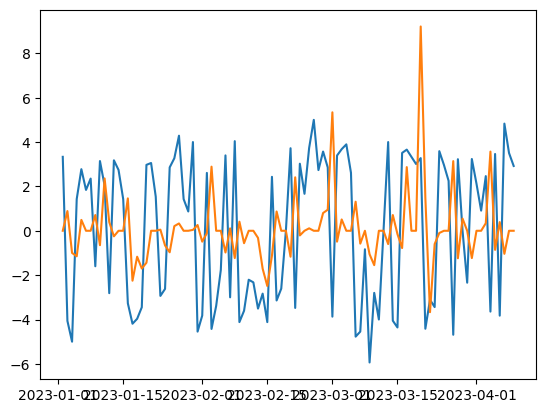

In [166]:
import matplotlib.pyplot as plt
plt.plot(dates[1:], [s * 10 for s in scores[1:]])
difference = []
for i in range(1, len(prices_list)):
    difference.append(prices_list[i] - prices_list[i - 1])
plt.plot(dates[1:], difference)
import numpy as np
print(np.corrcoef(np.array(scores[1:]), np.array(difference)))

In [167]:
with open("./exog.txt", 'w') as outf:
    for score in scores:
        outf.write(str(score) + "\n")
with open("./endog.txt", 'w') as outf:
    for price in prices_list:
        outf.write(str(price) + "\n")
with open("./dates.txt", 'w') as outf:
    for date in dates:
        outf.write(str(date) + "\n")

In [134]:
predicted_prices = []
with open("./predicted.txt") as inf:
    for line in inf.readlines():
        predicted_prices.append(float(line[:-1]))

In [140]:
predicted_prices = np.array(predicted_prices)
predicted_signs = predicted_prices[1:] - predicted_prices[:-1]
for i in range(predicted_signs.shape[0]):
    predicted_signs[i] = 0 if predicted_signs[i] == 0 else 1 if predicted_signs[i] > 0 else -1

In [149]:
new_y = []
classes = [-1, 0, 1]
for i in range(y.shape[0]):
    new_y.append(classes[torch.argmax(y[i])])

In [150]:
new_y = new_y[-827:]
print(len(new_y))
print(predicted_signs.shape[0])

827
827


In [151]:
sum(new_y[i] == predicted_signs[i] for i in range(len(new_y)))    

279